# 데이터셋 로드

In [14]:
import ujson
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# 파일 경로 (gpt-4o-mini는 summary_ner, 3.5-turbo는 cyner_sum_results_250427)
original_path = "original_ner.json"
summary_path_4o = "summary_ner.json"
summary_path_35 = "cyner_sum_results_250427.json"

# JSON 로드
with open(original_path, "r") as f:
    original_data = ujson.load(f)
with open(summary_path_4o, "r") as f:
    summary_data_4o = ujson.load(f)
with open(summary_path_35, "r") as f:
    summary_data_35 = ujson.load(f)

In [15]:
print(len(original_data))
print(len(summary_data_4o))
print(len(summary_data_35))

4940
4940
4940


# 초기 설정

In [16]:
# NER 레이블 종류
LABELS = ["Malware", "System", "Indicator", "Vulnerability", "Organization"]
LABELS_DISPLAY = ['MAL', 'SYS', 'IND', 'VUL', 'ORG']

# 전체 통계 저장
label_freq_stats_4o = {label: {'y_true': 0, 'y_pred': 0} for label in LABELS}
label_stats_4o = {label: {'y_true': [], 'y_pred': []} for label in LABELS}
label_freq_stats_35 = {label: {'y_true': 0, 'y_pred': 0} for label in LABELS}
label_stats_35 = {label: {'y_true': [], 'y_pred': []} for label in LABELS}
doc_stats_4o, doc_stats_35 = {}, {}
loss_vectors_4o, loss_vectors_35 = [], []
false_positives_4o, false_positives_35 = {}, {}

# Prec, Recall, f1-score 산출 및 출력

In [17]:
def evaluate(summary_path, summary_data, label_stats, label_freq_stats, doc_stats, false_positives, loss_vectors):
    for doc_id in summary_data:
        orig = original_data[doc_id]
        summ = summary_data[doc_id]

        # doc_id 문서에서의 true, pred
        doc_y_true = []
        doc_y_pred = []

        for label in LABELS:
            true_entities = set(orig.get(label, []))

            if summary_path == "summary_ner_3.5.json":
                preprocessed_pred_entities = set(summ.get(label, []))
                pred_entities = set()
                for entity in preprocessed_pred_entities:
                    pred_entities.update(set(map(lambda x: x.strip(), entity.split(','))))
            else:
                pred_entities = set(summ.get(label, []))

            # False Positives 저장
            fp_entities = pred_entities - true_entities
            if fp_entities:
                if doc_id not in false_positives:
                    false_positives[doc_id] = {}
                false_positives[doc_id][label] = list(fp_entities)

            for true in true_entities:
                label_stats[label]['y_true'].append(1)
                label_stats[label]['y_pred'].append(1 if true in pred_entities else 0)
                label_freq_stats[label]['y_true'] += 1
                label_freq_stats[label]['y_pred'] += 1 if true in pred_entities else 0
                doc_y_true.append(1)
                doc_y_pred.append(1 if true in pred_entities else 0)

            for pred_item in pred_entities:
                if pred_item not in true_entities:
                    label_stats[label]['y_true'].append(0)
                    label_stats[label]['y_pred'].append(1)
                    label_freq_stats[label]['y_pred'] += 1
                    doc_y_true.append(0)
                    doc_y_pred.append(1)

        # 모든 문서에서 loss 계산
        orig_counts = np.array([len(orig.get(label, [])) for label in LABELS])
        summ_counts = np.array([len(summ.get(label, [])) for label in LABELS])

        # 정규화
        orig_total = orig_counts.sum()
        summ_total = summ_counts.sum()

        orig_ratio = orig_counts / orig_total if orig_total != 0 else np.zeros(len(LABELS))
        summ_ratio = summ_counts / summ_total if summ_total != 0 else np.zeros(len(LABELS))

        loss = np.abs(orig_ratio - summ_ratio)
        loss_vectors.append(loss)

        # 문서별 precision/recall/f1 계산
        precision, recall, f1, _ = precision_recall_fscore_support(
            doc_y_true, doc_y_pred, average='binary', zero_division=0
        )
        doc_stats[doc_id] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    loss_matrix = np.array(loss_vectors) #shape = (4940, 5)

    # FP 저장
    if summary_path == summary_path_35:
        fp_savepath = "false_positives_gpt35.json"
        modelname = "gpt-3.5-turbo"
    elif summary_path == summary_path_4o:
        fp_savepath = "false_positives_gpt4o.json"
        modelname = "gpt-4o-mini"

    with open(fp_savepath, "w") as f:
        ujson.dump(false_positives, f, indent=4)

    return modelname, doc_stats, loss_matrix

In [43]:
# 모든 문서에서 loss 계산
orig_counts = np.array([4,5,6,0,3])
summ_counts = np.array([1,3,0,0,1])

# 정규화
orig_total = orig_counts.sum()
summ_total = summ_counts.sum()

orig_ratio = orig_counts / orig_total if orig_total != 0 else np.zeros(len(LABELS))
summ_ratio = summ_counts / summ_total if summ_total != 0 else np.zeros(len(LABELS))

loss = np.abs(orig_ratio - summ_ratio)

print(f"orig_counts : {orig_counts}")
print(f"summ_counts : {summ_counts}")
print(f"orig_total : {orig_total}")
print(f"summ_total : {summ_total}")
print(f"orig_ratio : {orig_ratio}")
print(f"summ_ratio : {summ_ratio}")
print(f"loss : {loss}")
print(1 - sum(loss))

orig_counts : [4 5 6 0 3]
summ_counts : [1 3 0 0 1]
orig_total : 18
summ_total : 5
orig_ratio : [0.22222222 0.27777778 0.33333333 0.         0.16666667]
summ_ratio : [0.2 0.6 0.  0.  0.2]
loss : [0.02222222 0.32222222 0.33333333 0.         0.03333333]
0.288888888888889


In [18]:
def print_evaluation_results(modelname, label_stats, label_freq_stats):
    # 해당 모델명 출력
    print()
    print("-"*15)
    print(f"\nEvaluate Dataset Path : {modelname}")

    # label별 정밀도, 재현율, F1 출력
    print("Label-wise Metrics:")
    total_true = []
    total_pred = []
    for label in LABELS:
        y_true = label_stats[label]['y_true']
        y_pred = label_stats[label]['y_pred']
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        fdr = fp / (fp + tp)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='binary', zero_division=0
        )
        print(f"🔹 {label}")
        print(f"   Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, FDR: {fdr:.4f}")
        total_true.extend(y_true)
        total_pred.extend(y_pred)

    t_prec, t_recall, t_f1, _ = precision_recall_fscore_support(
        total_true, total_pred, average='binary', zero_division=0
    )
    total_tn, total_fp, total_fn, total_tp = confusion_matrix(total_true, total_pred).ravel()
    total_fdr = total_fp / (total_fp + total_tp)
    print(f"Total Precision: {t_prec:.4f}, Total recall: {t_recall:.4f}, Total F1: {t_f1:.4f}, Total FDR: {total_fdr:.4f}")

    print("\nLabel Frequency")
    for label in LABELS:
        y_true = label_freq_stats[label]['y_true']
        y_pred = label_freq_stats[label]['y_pred']

        print(f"{label} - 원문: {y_true}개, 요약문: {y_pred}개")

## `gpt-4o-mini` Evaluation

In [19]:
modelname_4o, doc_stats_4o, loss_matrix_4o = evaluate(
        summary_path = summary_path_4o,
        summary_data = summary_data_4o,
        label_stats = label_stats_4o,
        label_freq_stats = label_freq_stats_4o,
        doc_stats = doc_stats_4o,
        false_positives = false_positives_4o,
        loss_vectors = loss_vectors_4o
    )
print_evaluation_results(modelname_4o, label_stats_4o, label_freq_stats_4o)


---------------

Evaluate Dataset Path : gpt-4o-mini
Label-wise Metrics:
🔹 Malware
   Precision: 0.7401, Recall: 0.2241, F1: 0.3440, FDR: 0.2599
🔹 System
   Precision: 0.7187, Recall: 0.1924, F1: 0.3036, FDR: 0.2813
🔹 Indicator
   Precision: 0.4977, Recall: 0.0315, F1: 0.0593, FDR: 0.5023
🔹 Vulnerability
   Precision: 0.1775, Recall: 0.0717, F1: 0.1022, FDR: 0.8225
🔹 Organization
   Precision: 0.7641, Recall: 0.1786, F1: 0.2895, FDR: 0.2359
Total Precision: 0.7020, Total recall: 0.1822, Total F1: 0.2893, Total FDR: 0.2980

Label Frequency
Malware - 원문: 17325개, 요약문: 5245개
System - 원문: 16692개, 요약문: 4469개
Indicator - 원문: 3364개, 요약문: 213개
Vulnerability - 원문: 2733개, 요약문: 1104개
Organization - 원문: 24007개, 요약문: 5612개


## `gpt-3.5-turbo` Evaluation

In [20]:
modelname_35, doc_stats_35, loss_matrix_35 = evaluate(
    summary_path=summary_path_35,
    summary_data=summary_data_35,
    label_stats=label_stats_35,
    label_freq_stats=label_freq_stats_35,
    doc_stats=doc_stats_35,
    false_positives=false_positives_35,
    loss_vectors=loss_vectors_35
)
print_evaluation_results(modelname_35, label_stats_35, label_freq_stats_35)


---------------

Evaluate Dataset Path : gpt-3.5-turbo
Label-wise Metrics:
🔹 Malware
   Precision: 0.6979, Recall: 0.2199, F1: 0.3344, FDR: 0.3021
🔹 System
   Precision: 0.6800, Recall: 0.1885, F1: 0.2952, FDR: 0.3200
🔹 Indicator
   Precision: 0.4000, Recall: 0.0291, F1: 0.0543, FDR: 0.6000
🔹 Vulnerability
   Precision: 0.1923, Recall: 0.0714, F1: 0.1041, FDR: 0.8077
🔹 Organization
   Precision: 0.7377, Recall: 0.1637, F1: 0.2679, FDR: 0.2623
Total Precision: 0.6705, Total recall: 0.1743, Total F1: 0.2767, Total FDR: 0.3295

Label Frequency
Malware - 원문: 17325개, 요약문: 5459개
System - 원문: 16692개, 요약문: 4628개
Indicator - 원문: 3364개, 요약문: 245개
Vulnerability - 원문: 2733개, 요약문: 1014개
Organization - 원문: 24007개, 요약문: 5326개


# Dataframe 셋업

In [21]:
def init_dataframe_docs(doc_stats):
    df_doc = pd.DataFrame.from_dict(doc_stats, orient='index')
    df_doc.index.name = 'doc_id'
    df_doc.sort_index(inplace=True)
    return df_doc

In [22]:
df_doc_4o = init_dataframe_docs(doc_stats_4o)
df_doc_35 = init_dataframe_docs(doc_stats_35)

# CDF for Prec, Recall, F1-Score
> Abstractive Summary - Cosine Similarity 에 대한 누적분포함수

In [23]:
def cdf_prec_recall(df_doc_4o, df_doc_35):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # 논문용 가로형 작게

    model_labels = ['gpt-4o-mini', 'gpt-3.5-turbo']
    model_colors = {
        'gpt-4o-mini': 'green',
        'gpt-3.5-turbo': 'orange'
    }

    for i, metric in enumerate(['precision', 'recall']):
        ax = axes[i]
        for df_doc, model_name in zip([df_doc_4o, df_doc_35], model_labels):
            values = df_doc[metric].dropna().values
            sorted_vals = np.sort(values)
            cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
            ax.plot(sorted_vals, cdf, label=model_name, color=model_colors[model_name])

        ax.set_xlabel("Score", fontsize=9)
        if i == 0:
            ax.set_ylabel("Cumulative Probability", fontsize=9)
        ax.set_title(metric.capitalize(), fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(fontsize=8, loc='lower right', title='Model', title_fontsize=8)

    plt.tight_layout()
    plt.savefig("figures/figure5.pdf", dpi=300)
    plt.show()

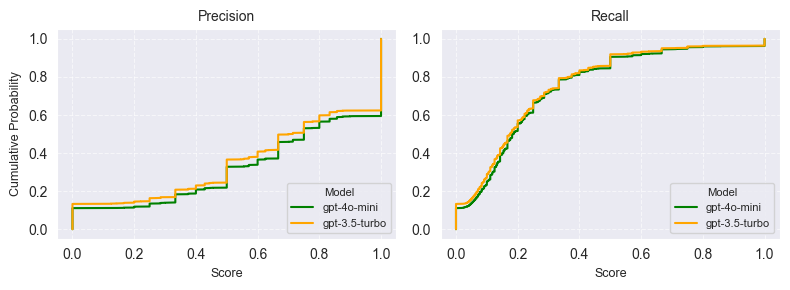

In [24]:
cdf_prec_recall(df_doc_4o, df_doc_35)

# Frequency-based Entity Similarity
> Frequency-based 매트릭에 대한 그래프

In [25]:
# def freq_based_entity_similarity(label_freq_stats_4o, label_freq_stats_35):
#     # gpt-4o-mini
#     true_counts_4o = [label_freq_stats_4o[l]["y_true"] for l in LABELS]
#     pred_counts_4o = [label_freq_stats_4o[l]["y_pred"] for l in LABELS]
#     true_pct_4o = [x / sum(true_counts_4o) * 100 for x in true_counts_4o]
#     pred_pct_4o = [x / sum(pred_counts_4o) * 100 for x in pred_counts_4o]
#
#     # gpt-3.5-turbo
#     true_counts_35 = [label_freq_stats_35[l]["y_true"] for l in LABELS]
#     pred_counts_35 = [label_freq_stats_35[l]["y_pred"] for l in LABELS]
#     true_pct_35 = [x / sum(true_counts_35) * 100 for x in true_counts_35]
#     pred_pct_35 = [x / sum(pred_counts_35) * 100 for x in pred_counts_35]
#
#     # Subplots
#     fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
#
#     for ax, model_name, true_pct, pred_pct in zip(
#             axes,
#             ['gpt-4o-mini', 'gpt-3.5-turbo'],
#             [true_pct_4o, true_pct_35],
#             [pred_pct_4o, pred_pct_35]
#     ):
#         ax.plot(LABELS_DISPLAY, true_pct, marker='o', linestyle='-', label='Original')
#         ax.plot(LABELS_DISPLAY, pred_pct, marker='s', linestyle='--', label='Summary')
#         ax.set_title(model_name, fontsize=10)
#         ax.set_xlabel("Entity Label", fontsize=9)
#         ax.legend(fontsize=8, )
#         ax.grid(True, linestyle='--', alpha=0.5)
#
#     axes[0].set_ylabel("Entity Frequency (%)", fontsize=9)
#
#     plt.tight_layout()
#     plt.savefig('figures/figure6.pdf', dpi=300)
#     plt.show()

In [26]:
def freq_based_entity_similarity(label_freq_stats, modelname):
    true_counts = [label_freq_stats[l]["y_true"] for l in LABELS]
    pred_counts = [label_freq_stats[l]["y_pred"] for l in LABELS]

    true_pct = [x / sum(true_counts) * 100 for x in true_counts]
    pred_pct = [x / sum(pred_counts) * 100 for x in pred_counts]

    l1_distance = sum(abs(t - p) for t, p in zip(true_pct, pred_pct))

    plt.style.use('default')
    plt.figure(figsize=(7,5))
    plt.plot(LABELS, true_pct, marker='o', linestyle='--', label='Original')
    plt.plot(LABELS, pred_pct, marker='s', linestyle='--', label='Summary')

    plt.title(f"F = {l1_distance:.3f}", fontsize=10)
    plt.xlabel("Entity Label", fontsize=9)
    plt.ylabel("Entity Frequency(%)", fontsize=9)
    plt.legend(loc='lower right', prop={'size': 9})
    plt.grid(True, linestyle="-", alpha=0.5)

    plt.tight_layout()
    plt.savefig(f'figures/figure6_entity_{modelname}.pdf', dpi=300)
    plt.show()

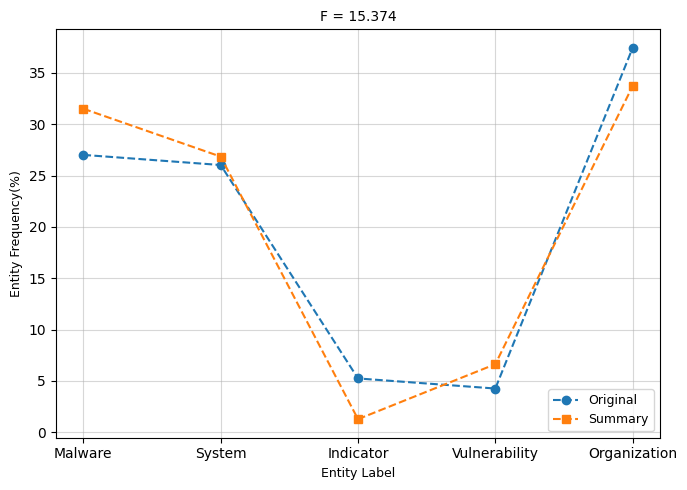

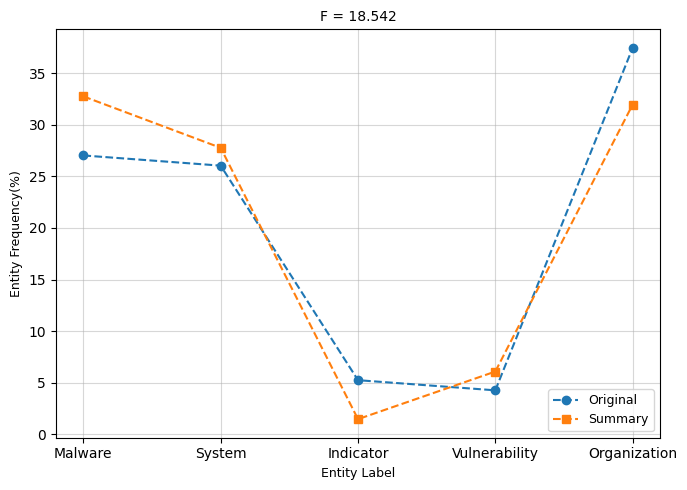

In [27]:
freq_based_entity_similarity(label_freq_stats_4o, '4o')
freq_based_entity_similarity(label_freq_stats_35, '35')

# loss vector를 이용한 CDF

In [72]:
import numpy as np
import matplotlib.pyplot as plt

def plot_loss_cdf(loss_matrix, labels, modelname):
    num_articles = loss_matrix.shape[0]
    num_labels = loss_matrix.shape[1]
    plt.figure(figsize=(7, 5))
    label_median, label_mean, L1_distances = [], [], []

    for i in range(num_labels):
        label_losses = 1-loss_matrix[:, i]
        sorted_losses = np.sort(label_losses)
        label_median.append(np.median(sorted_losses))
        label_mean.append(np.mean(sorted_losses))
        cdf = np.arange(1, len(sorted_losses) + 1) / len(sorted_losses)
        plt.plot(sorted_losses, cdf, label=labels[i])

    plt.xlabel("Score")
    plt.ylabel("Cumulative Probability")
    plt.legend(loc='upper left')
    plt.grid(True)

    # 화살표
    plt.annotate(
        text='better',
        xy=(0.55,0.55),
        xytext=(0.45,0.65),
        xycoords='axes fraction',
        textcoords='axes fraction',
        arrowprops=dict(arrowstyle='->', color='black', lw=2)
    )

    plt.tight_layout()
    plt.savefig(f"figures/L1_cdf_{modelname}.pdf")
    plt.show()

    print("[MEDIAN]")
    for i, label in enumerate(LABELS):
        print(f"{label}: {label_median[i]:.4f}", end=', ')
    print("\n[MEAN]")
    for i, label in enumerate(LABELS):
        print(f"{label}: {label_mean[i]:.4f}", end=', ')
    print()

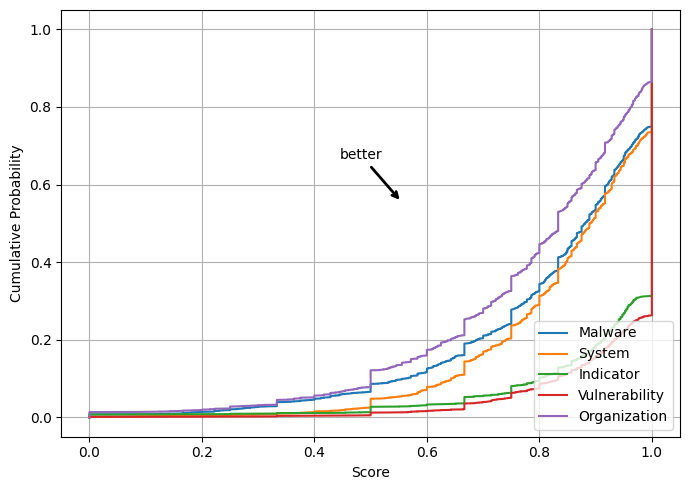

[MEDIAN]
Malware: 0.8812, System: 0.8901, Indicator: 1.0000, Vulnerability: 1.0000, Organization: 0.8333, 
[MEAN]
Malware: 0.8249, System: 0.8516, Indicator: 0.9414, Vulnerability: 0.9559, Organization: 0.7824, 


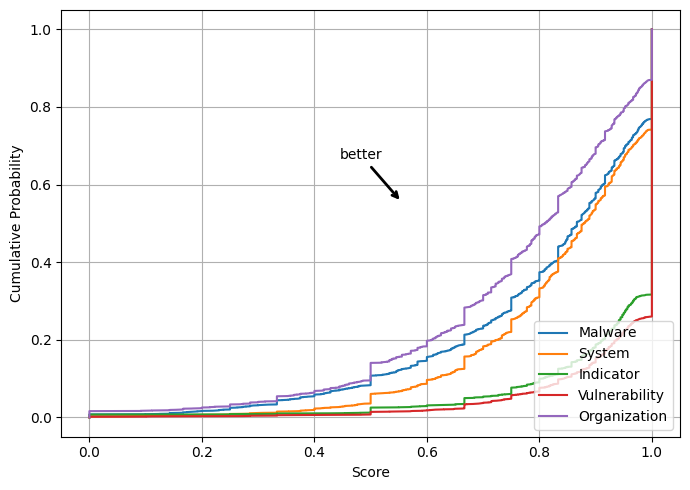

[MEDIAN]
Malware: 0.8667, System: 0.8788, Indicator: 1.0000, Vulnerability: 1.0000, Organization: 0.8095, 
[MEAN]
Malware: 0.8093, System: 0.8414, Indicator: 0.9427, Vulnerability: 0.9569, Organization: 0.7635, 


In [73]:
plot_loss_cdf(loss_matrix_4o, LABELS, "4o")
plot_loss_cdf(loss_matrix_35, LABELS, "35")

# L1-Distance Similarity

In [78]:
import numpy as np
import matplotlib.pyplot as plt

def plot_loss_cdf(loss_matrix_4o, loss_matrix_35, labels):
    num_articles = loss_matrix_4o.shape[0]
    num_labels = loss_matrix_4o.shape[1]

    plt.figure(figsize=(7, 5))
    L1_distances_4o = []
    L1_distances_35 = []

    L1_distances_4o = [1-(sum(loss_matrix_4o[i, :])/2) for i in range(num_articles)]
    sorted_L1_distances_4o = np.sort(L1_distances_4o)
    cdf_4o = np.arange(1, len(sorted_L1_distances_4o) + 1) / len(sorted_L1_distances_4o)
    plt.plot(sorted_L1_distances_4o, cdf_4o, label="gpt-4o-mini")

    L1_distances_35 = [1-(sum(loss_matrix_35[i, :])/2) for i in range(num_articles)]
    sorted_L1_distances_35 = np.sort(L1_distances_35)
    cdf_35 = np.arange(1, len(sorted_L1_distances_35) + 1) / len(sorted_L1_distances_35)
    plt.plot(sorted_L1_distances_35, cdf_35, label="gpt-3.5-turbo")



    plt.xlabel("Score")
    plt.ylabel("Cumulative Probability")
    plt.legend(loc='upper left')
    plt.grid(True)

    # 화살표
    plt.annotate(
        text='better',
        xy=(0.55,0.55),
        xytext=(0.45,0.65),
        xycoords='axes fraction',
        textcoords='axes fraction',
        arrowprops=dict(arrowstyle='->', color='black', lw=2)
    )

    plt.tight_layout()
    plt.savefig(f"figures/L1_distance_cdf.pdf")
    plt.show()
    #
    # print("[MEDIAN]")
    # for i, label in enumerate(LABELS):
    #     print(f"{label}: {label_median[i]:.4f}", end=', ')
    # print("\n[MEAN]")
    # for i, label in enumerate(LABELS):
    #     print(f"{label}: {label_mean[i]:.4f}", end=', ')
    # print()

gpt-4o-mini @CDF=0.5: 0.6941
gpt-3.5-turbo @CDF=0.5: 0.6667
gpt-4o-mini @CDF=0.9: 0.9333
gpt-3.5-turbo @CDF=0.9: 0.9286


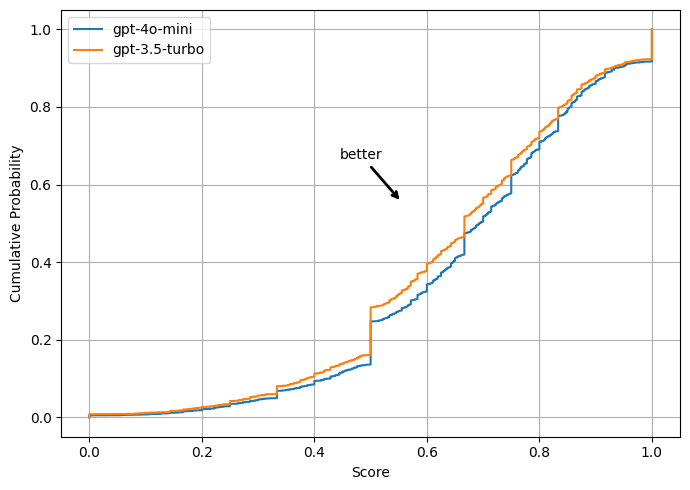

In [79]:
plot_loss_cdf(loss_matrix_4o,loss_matrix_35,LABELS)

# Boxplot

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_loss_matrix_boxplot(loss_matrix):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=loss_matrix, width=0.5)
    plt.xticks(ticks=range(len(LABELS)), labels=LABELS)
    plt.ylabel('Loss Value')
    plt.title("Distribution of Loss per Label")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("figures/boxplot.pdf")
    plt.show()

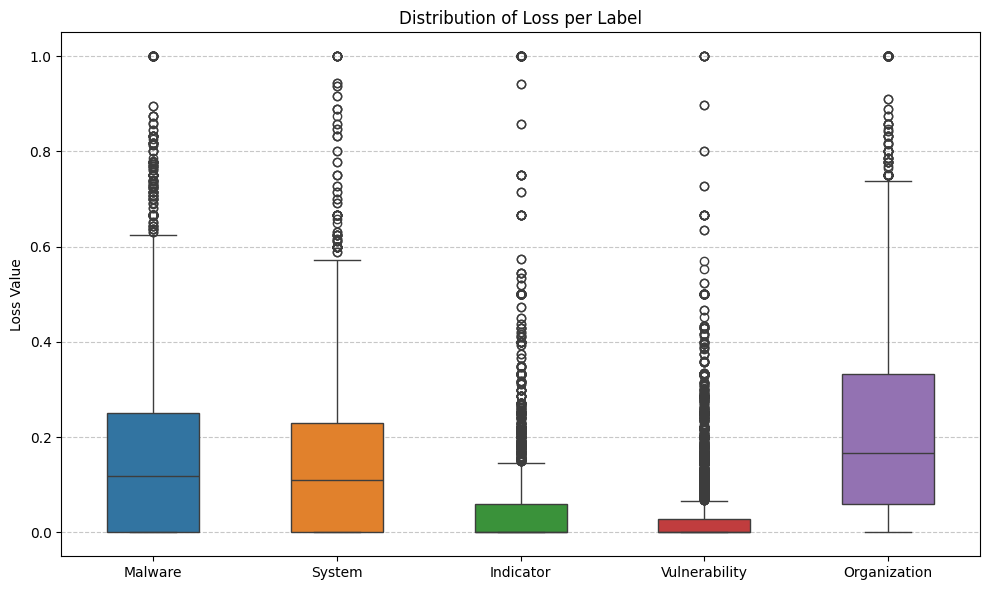

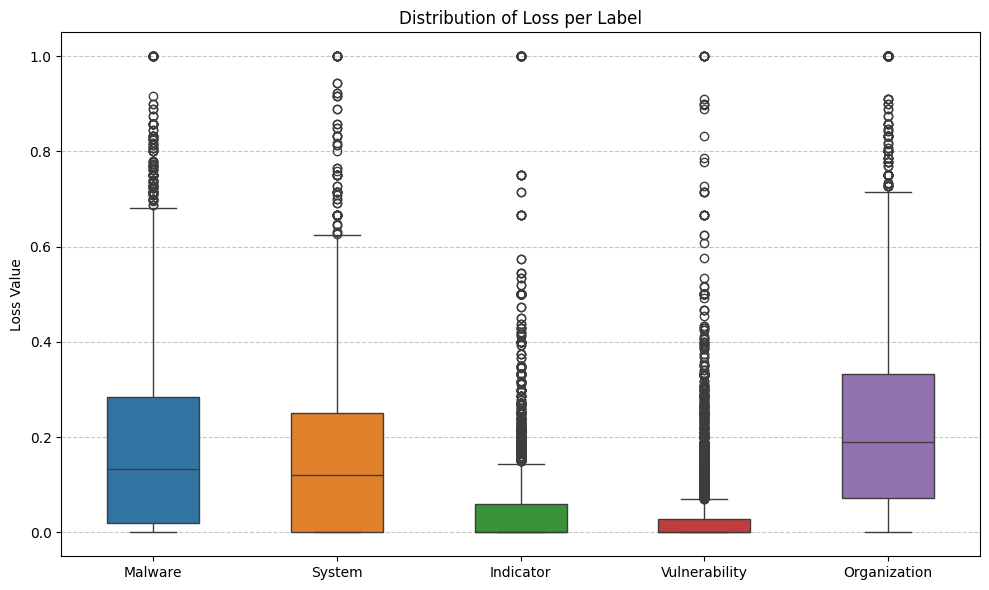

In [31]:
plot_loss_matrix_boxplot(loss_matrix_4o)
plot_loss_matrix_boxplot(loss_matrix_35)

# Graph

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def freq_based_loss_similarity(loss_matrix):
    plt.figure(figsize=(10,6))
    for label in LABELS:
        plt.plot(loss_matrix)